# Model Remnant Quantities

## NOTES

* This notebook creates fits for the final mass and spin of precessing simulations used for calibration of the mode PhenomPNR
* These are single spin systems where the initial spin is only on the larger BH
* Here final mass and spin are modeled as deviations from the non-precessing fit published in https://arxiv.org/abs/1611.00332
* The fitting ansatzes are as follows

    \begin{align}
        \chi_f \; = \; \chi_f^{\mathrm{NonPrecessing}} \, + \, \chi_p \, \sigma(u,\eta,a_1) 
        \\
        M_f \; = \; M_f^{\mathrm{NonPrecessing}} \, + \, \chi_p \, \rho(u,\eta,a_1) 
    \end{align}

where $u=\cos(\theta_\mathrm{LS})$, $\eta=m_1 m_2 / (m_1+m_2)^2$, and $a_1=|\chi_1|$.
* Two fits are created for $\sigma$. One is a rational function fit, and the other is a polynomial fit. The related fitting objects are `foo` and `foo2`.
* One fit for $\rho$ is created. It is stored in `foo3`.
* Plots are created to visualize raw data (and related outlier detection and correction), as well as fit behavior within and outside of the calibration region.
* Lastly, fits are stored to individual files at the bottom of this notebook.

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
from matplotlib.pyplot import *
from numpy import *
from positive import *
from nrutils import scsearch, gwylm
from pwca import *
from glob import glob
import lalsimulation as lalsim

(positive)>> Applying custom matplotlib settings.
(init)>> Warm greetings from Welsh Puck (aka pwca).
(pwca.core)>> Catalog of calibration runs stored to "pwca.pwca_catalog"
(pwca.core)>> Metadata dictionary for calibration runs stored to "pwca.metadata_dict"
(pwca.core)>> Metadata dictionary for Ed's catalog paper stored to "pwca.catalog_paper_metadata"


# Collect Data

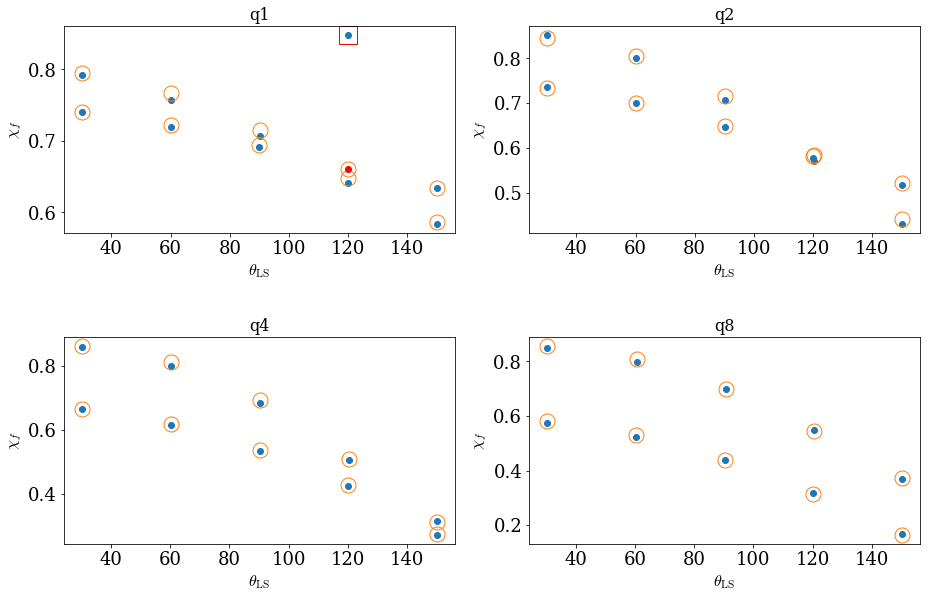

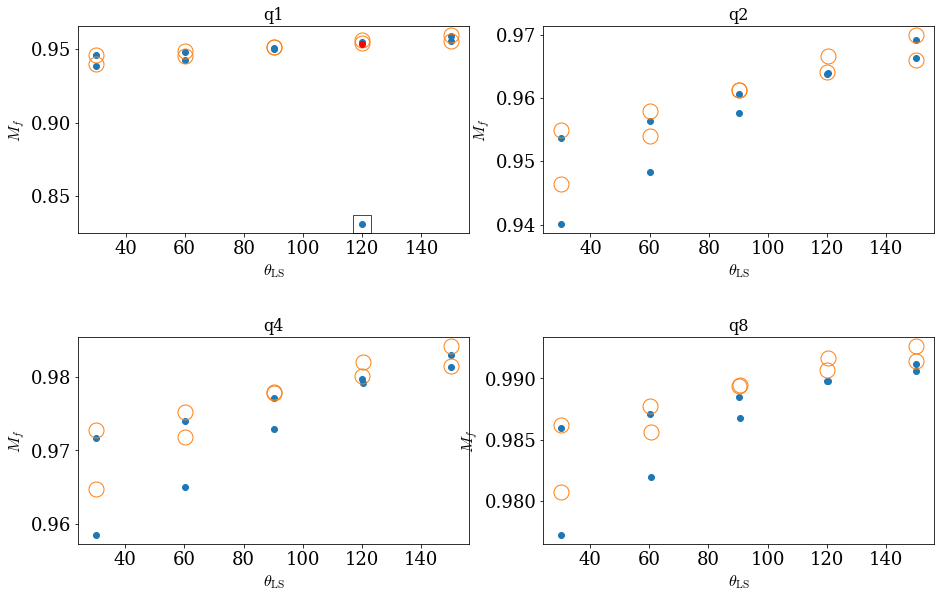

In [431]:

#
from phenom import FinalSpinIMRPhenomD_all_in_plane_spin_on_larger_BH

#
fig,ax = subplots(2,2,figsize=2*figaspect(0.618))
ax = ax.flatten()
tight_layout(w_pad=2,h_pad=6)

#
fig2,ax2 = subplots(2,2,figsize=2*figaspect(0.618))
ax2 = ax2.flatten()
tight_layout(w_pad=2,h_pad=6)

#
xf_range = []
mf_range = []
chip_domain = []
eta_domain = []
a1_domain = []
chi1_domain = []
chi2_domain = []
th_domain = []
u_domain = []
mfnp_range = []
xfnp_range = []

#
for k,qkey in enumerate(['q1','q2','q4','q8']):

    #
    xf = []
    th = []
    u = []
    mf = []
    a1 = []
    xfd = []
    chi1,chi2 = [],[]
    chip,eta = [],[]
    MfNP = []
    XfNP = []
    
    #
    for a in pwca_catalog:
        
        if qkey in a.simname:
            
            #
            if abs(a.m1-a.m2)<1e-02:
                if linalg.norm(a.X1)<linalg.norm(a.X2):
                    X1 = a.X2; X2 = a.X1
                    a.X1,a.X2 = X1,X2
                    S1 = a.S2; S2 = a.S1
                    a.S1,a.S2 = S1,S2
            
            #
            u_ = dot(a.L,a.S)  /  ( linalg.norm(a.L) * linalg.norm(a.S) )
            th_ = 180 * arccos( u_ ) / pi
            chi_p_ = calc_chi_p(a.m1,a.X1,a.m2,a.X2,a.L)
            chi1_ = dot(a.X1,a.L)/linalg.norm(a.L)
            chi2_ = dot(a.X2,a.L)/linalg.norm(a.L)
            xfd_ = abs(FinalSpinIMRPhenomD_all_in_plane_spin_on_larger_BH(a.m1, a.m2, chi_p_, chi1_, chi2_))
            
            #
            MfNP_ = Mf161100332(a.m1,a.m2,chi1_,chi2_) # abs(FinalSpinIMRPhenomD_all_in_plane_spin_on_larger_BH(a.m1, a.m2, chi_p, chi1, chi2))
            MfNP.append(MfNP_)
            
            #
            XfNP_ = jf161100332(a.m1,a.m2,chi1_,chi2_) 
            XfNP.append(XfNP_)
            
            #
            xfd.append(xfd_)
            th.append(th_)
            u.append(u_)
            a1.append( max(linalg.norm(a.X1),linalg.norm(a.X2)) )
            xf.append(abs(a.xf))
            mf.append(a.mf)
            chi1.append(chi1_)
            chi2.append(chi2_)
            chip.append(chi_p_)
            eta.append( min(a.eta,0.25) )
            

    #
    xf,th,u,mf,a1,xfd,chi1,chi2,chip,eta,MfNP,XfNP = [ array(z).T for z in (xf,th,u,mf,a1,xfd,chi1,chi2,chip,eta,MfNP,XfNP) ]

    #
    th_ = th
    xf,th,u,mf,a1,xfd,chi1,chi2,chip,eta,MfNP,XfNP = [ z[argsort(th_)] for z in (xf,th,u,mf,a1,xfd,chi1,chi2,chip,eta,MfNP,XfNP) ]
    
    #
    r = abs((xf - xfd)/xfd)
    mask = r>0.1
    
    #
    sca(ax[k])
    
    plot( th, xf, 'o' )
    plot( th, xfd, marker='o',mfc='none',ls='none',ms=15 )
    
    plot( th[mask],xf[mask],marker='s',mfc='none',ms=18,color='r' )
    
    xf[mask] = xfd[mask]
    
    plot( th[mask],xf[mask],marker='o',color='red' )
    
    title(qkey)
    xlabel(r'$\theta_{\mathrm{LS}}$')
    ylabel(r'$\chi_f$')
    
    #
    sca(ax2[k])
    
    plot( th, mf, 'o' )
    plot( th, MfNP, marker='o',mfc='none',ls='none',ms=15 )
    
    #
    r = abs((mf - MfNP)/MfNP)
    mask = r>0.1
    
    #
    plot( th[mask],mf[mask],marker='s',mfc='none',ms=18,color='r' )
    
    # !!!!!!!!!!!!!!
    mf[mask] = 0.99955*MfNP[mask]
    
    plot( th[mask],mf[mask],marker='o',color='red' )
    
    title(qkey)
    xlabel(r'$\theta_{\mathrm{LS}}$')
    ylabel(r'$M_f$')
    
    #
    xf_range += xf.tolist() 
    mf_range += mf.tolist() 
    xfnp_range += XfNP.tolist() 
    mfnp_range += MfNP.tolist() 
    th_domain += th.tolist() 
    u_domain += u.tolist() 
    chi1_domain += chi1.tolist() 
    chi2_domain += chi2.tolist() 
    chip_domain += chip.tolist() 
    eta_domain += eta.tolist() 
    a1_domain += a1.tolist() 
    
#
xf_range,mf_range,xfnp_range,mfnp_range,th_domain,u_domain,chi1_domain,chi2_domain,chip_domain,eta_domain,a1_domain = [ array(z) for z in (xf_range,mf_range,xfnp_range,mfnp_range,th_domain,u_domain,chi1_domain,chi2_domain,chip_domain,eta_domain,a1_domain) ]

In [419]:
# 
delta_domain = sqrt(1-4*eta_domain)
model_domain = array( [u_domain,eta_domain,delta_domain,a1_domain] ).T
scalar_range = ( array( xf_range ).T - array( xfnp_range ).T ) / array(chip_domain).T
foo = gmvrfit( model_domain, scalar_range, fitatol=0.0001, verbose=True, maxdeg_list=[3,1,1,1],center=True)

(gmvrfit)>> Now working net monomial degree 1
&& The estimator has changed by -inf
&& Degree tempering will continue.
&& The current boundary is [('1', True), ('0', True), ('3', True), ('2', True), ('1', False), ('0', False)]
&& The current estimator value is 0.217625

(gmvrfit)>> Now working net monomial degree 2
&& The estimator has changed by -0.176596
&& Degree tempering will continue.
&& The current boundary is [('23', True), ('02', True), ('1', False), ('02', False), ('1', True), ('00', True), ('03', False), ('03', True), ('01', False), ('12', False), ('0', False), ('13', True), ('3', True), ('13', False), ('00', False), ('01', True), ('0', True)]
&& The current estimator value is 0.041029

(gmvrfit)>> Now working net monomial degree 3
&& The estimator has changed by -0.035485
&& Degree tempering will continue.
&& The current boundary is [('23', True), ('023', True), ('1', False), ('02', False), ('1', True), ('002', True), ('012', False), ('002', False), ('12', False), ('123', Tr

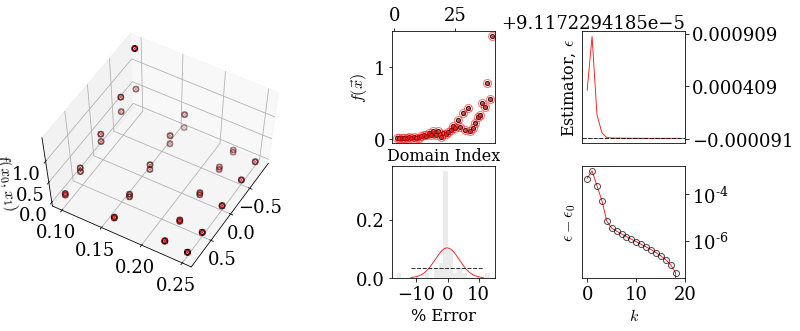

<Figure size 907.2x432 with 0 Axes>

In [346]:
foo.plot();

(gmvpfit)>> Now working deg = 1
&& The estimator has changed by -inf
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '1' '0']
&& The current estimator value is 0.614716

(gmvpfit)>> Now working deg = 2
&& The estimator has changed by -0.285411
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '13' '11' '1' '03' '01' '00' '0']
&& The current estimator value is 0.329304

(gmvpfit)>> Now working deg = 3
&& The estimator has changed by -0.156357
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '13' '113' '111' '11' '1' '03' '013' '011' '01' '003' '001' '000'
 '00' '0']
&& The current estimator value is 0.172948

(gmvpfit)>> Now working deg = 4
&& The estimator has changed by -0.087402
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '13' '113' '1113' '111' '11' '1' '03' '013' '0113' '0111' '011'
 '01' '003' '0013' '0011' '001' '0003' '0001' '0000' '000' '00' '0']
&& The current estimator value is 0.0855

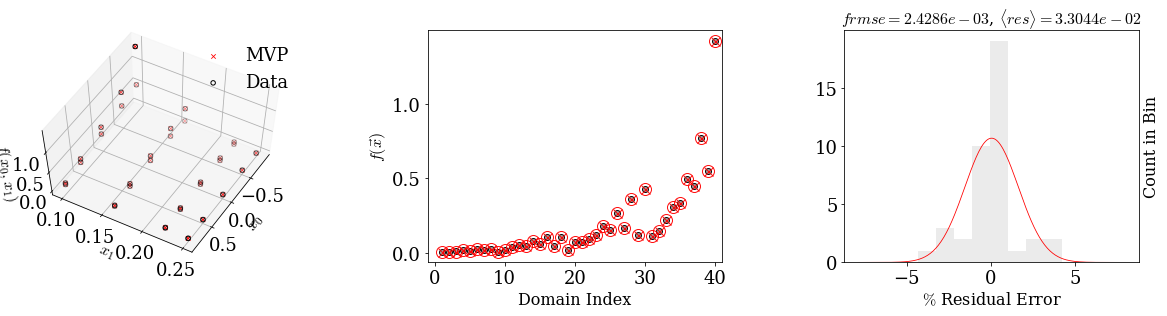

In [439]:
# 
model_domain = array( [u_domain,eta_domain,delta_domain,a1_domain] ).T
# model_domain = around(model_domain,4)
scalar_range = ( array( xf_range ).T - array( xfnp_range ).T ) / array(chip_domain).T

# #
# mask = argsort(eta_domain)
# model_domain = model_domain[mask,:]
# scalar_range = scalar_range[mask]

foo2 = gmvpfit( model_domain, scalar_range, fitatol=0.0001, verbose=True, maxdeg_list=[4,3,0,1],center=True)
foo2.plot();

In [440]:
# Advanced gloss atop mvpolyfit.plot and mvrfit.plot
def advanced_gmvx_plot( fit_object,theta_eta_a1=None,extrap=False ):
    
    '''
    Advanced gloss atop mvpolyfit.plot and mvrfit.plot
    '''
    
    from matplotlib.pyplot import subplots, plot, xlabel, ylabel, title, sca, gca, figaspect, tight_layout
    from numpy import cos,sin,array,around,ones_like,sort,pi,linspace
    from positive import eta2q,q2eta,eta2delta
    from glob import glob
    from pwca import determine_data_fitting_region,pwca_catalog,metadata_dict
    
    # Load and unpuack physical parameter space
    if theta_eta_a1:
        #
        theta,eta,a1 = theta_eta_a1
    else:
        raw_domain = loadtxt(data_dir+'version2/fit_intial_binary_parameters.txt')
        theta,m1,m2,eta,delta,chi_eff,chi_p,chi1,chi2,a1,a2 = raw_domain.T


    # Define desired model domain variables and array 
    u = cos(theta)
    v = sin(theta)
    q = 1.0/eta2q(eta)

    # --------------------------------------- #
    # Plot ans save fits 
    # --------------------------------------- #

    # Collect set of unique a1 values
    a1_point = around(a1,2)
    a1_set = array(sort(list( set(a1_point) )))

    # Collect set of unique angle values
    degree_point = (theta*180/pi).astype(int)
    theta_point = degree_point*pi/180
    theta_set = array(sort(list( set( theta_point ) )))

    # Collect set of unique mass-ratio values
    q_point = around(array([eta2q(n) for n in eta]),2)
    q_set = array(sort(list( set(q_point) )))

    # Collect set of unique eta values
    eta_point = q2eta( q_point )
    eta_set = q2eta(q_set)

    # Summary figure for internal diagnostics 
    summary_fig = fit_object.plot(size_scale=1.5)
    ax = summary_fig.axes
    
    #
    sca(ax[0])
    title(fit_object.labels['python'][0])
    
    #
    num_figs = len(a1_set)*len(theta_set)
    eta_set_figs,set_fig_ax = subplots( len(a1_set), len(theta_set), figsize=5*array([ len(theta_set),len(a1_set) ]) )
    set_fig_ax = set_fig_ax.flatten();
    tight_layout(4,4)
    ax_counter = 0

    #
    for _a1 in a1_set:
        for _theta in theta_set:

            #
            theta_mask = (_theta==theta_point)
            a1_mask = (_a1==a1_point)
            mask = a1_mask & theta_mask

            #
            _eta = eta_point[mask]
            _u = cos(_theta) 

            #
            if extrap:
                case_eta   = linspace( 0.08,max(_eta),400 ) 
            else:
                case_eta   = linspace( min(_eta),max(_eta),400 ) 
            
            case_delta = eta2delta( case_eta )
            case_q     = 1.0/eta2q(case_eta)  
            case_theta = _theta * ones_like(case_eta)
            case_u     = cos(case_theta)
            case_a1    = _a1    * ones_like(case_eta)

            #
            case_domain = array([case_u,case_eta,case_delta,case_a1]).T
            case_range = fit_object.eval(case_domain)
            opt_range  = fit_object.eval(fit_object.domain[mask,:])

            #
            sca(ax[0])
            ax[0].plot3D( case_u, case_eta, case_range, lw=1, alpha=1, color = 'tab:blue' if _a1==a1_set[0] else 'red' )
            
            #
            sca( set_fig_ax[ax_counter] ); ax_counter += 1
            plot( eta[mask], fit_object.range[mask] if hasattr(fit_object,'range') else fit_object.scalar_range[mask], marker='o',ls='none'  )
            plot( eta[mask], opt_range, marker='o',ms=10,mfc='none', color='r',ls='none'  )
            plot( case_eta, case_range, ls='-', color='r' )
            title( r'$a_1=%1.2f$, $\theta=%1.2f$'%(_a1,round(_theta*180.0/pi,0)) )
            xlabel(r'$\eta$')
            ylabel(r'$\%s$'%fit_object.labels['python'][0])
            

    
    #
    num_figs = len(a1_set)*len(eta_set)
    theta_set_figs,set_fig_ax = subplots( len(a1_set), len(eta_set), figsize=5*array([ len(eta_set),len(a1_set) ]) )
    set_fig_ax = set_fig_ax.flatten();
    tight_layout(4,4)
    ax_counter = 0

    #
    for _a1 in a1_set:
        for _eta in eta_set:

            #
            eta_mask = (_eta==eta_point)
            a1_mask = (_a1==a1_point)
            mask = a1_mask & eta_mask

            #
            _theta = theta_point[mask]
            _u = cos(_theta) 

            #
            if extrap:
                case_theta   = 0.99*pi*linspace( 0,1,400 ) 
            else:
                case_theta   = linspace( min(_theta),max(_theta),400 ) 
                
            # 
            case_u     = cos(case_theta)
            case_eta   = _eta * ones_like(case_theta)
            case_delta = eta2delta( case_eta )
            case_a1    = _a1  * ones_like(case_theta)

            #
            case_domain = array([case_u,case_eta,case_delta,case_a1]).T
            case_range = fit_object.eval(case_domain)
            opt_range  = fit_object.eval(fit_object.domain[mask,:])

            #
            sca(ax[0])
            ax[0].plot3D( case_u, case_eta, case_range, lw=1, alpha=1, color = 'tab:blue' if _a1==a1_set[0] else 'red' )
            
            #
            sca( set_fig_ax[ax_counter] ); ax_counter += 1
            plot( cos(theta[mask]), fit_object.range[mask] if hasattr(fit_object,'range') else fit_object.scalar_range[mask], marker='o',ls='none',color='r'  )
            plot( cos(theta[mask]), opt_range, marker='o',ms=10,mfc='none', color='b',ls='none'  )
            plot( cos(case_theta), case_range, ls='-', color='b' )
            title( r'$a_1=%1.2f$, $q=%1.2f$'%(_a1,eta2q(_eta)) )
            xlabel(r'$\cos(\theta)$')
            ylabel(r'$\%s$'%fit_object.labels['python'][0])
            
    #
    return summary_fig, eta_set_figs, theta_set_figs

In [442]:
key = 'sigma'
foo.labels={'python':[key,('u', 'eta', 'delta', 'a1'),''],'latex':['\\'+key,(r'\cos(\theta)', r'\eta', r'\delta', r'a_1'),'']}
foo2.labels={'python':[key,('u', 'eta', 'delta', 'a1'),''],'latex':['\\'+key,(r'\cos(\theta)', r'\eta', r'\delta', r'a_1'),'']}

(<Figure size 1101.6x453.6 with 5 Axes>,
 <Figure size 1800x720 with 10 Axes>,
 <Figure size 1440x720 with 8 Axes>)

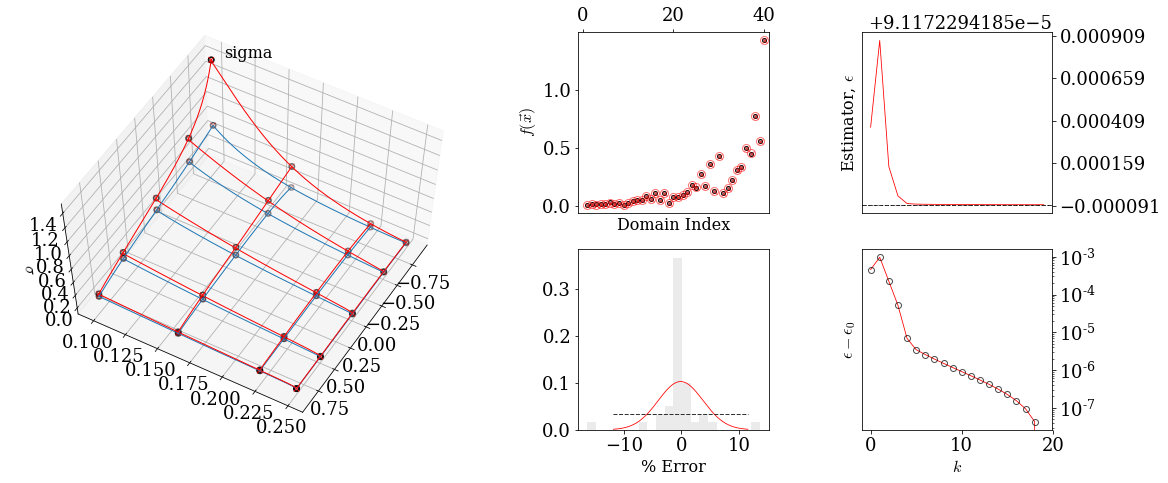

<Figure size 907.2x432 with 0 Axes>

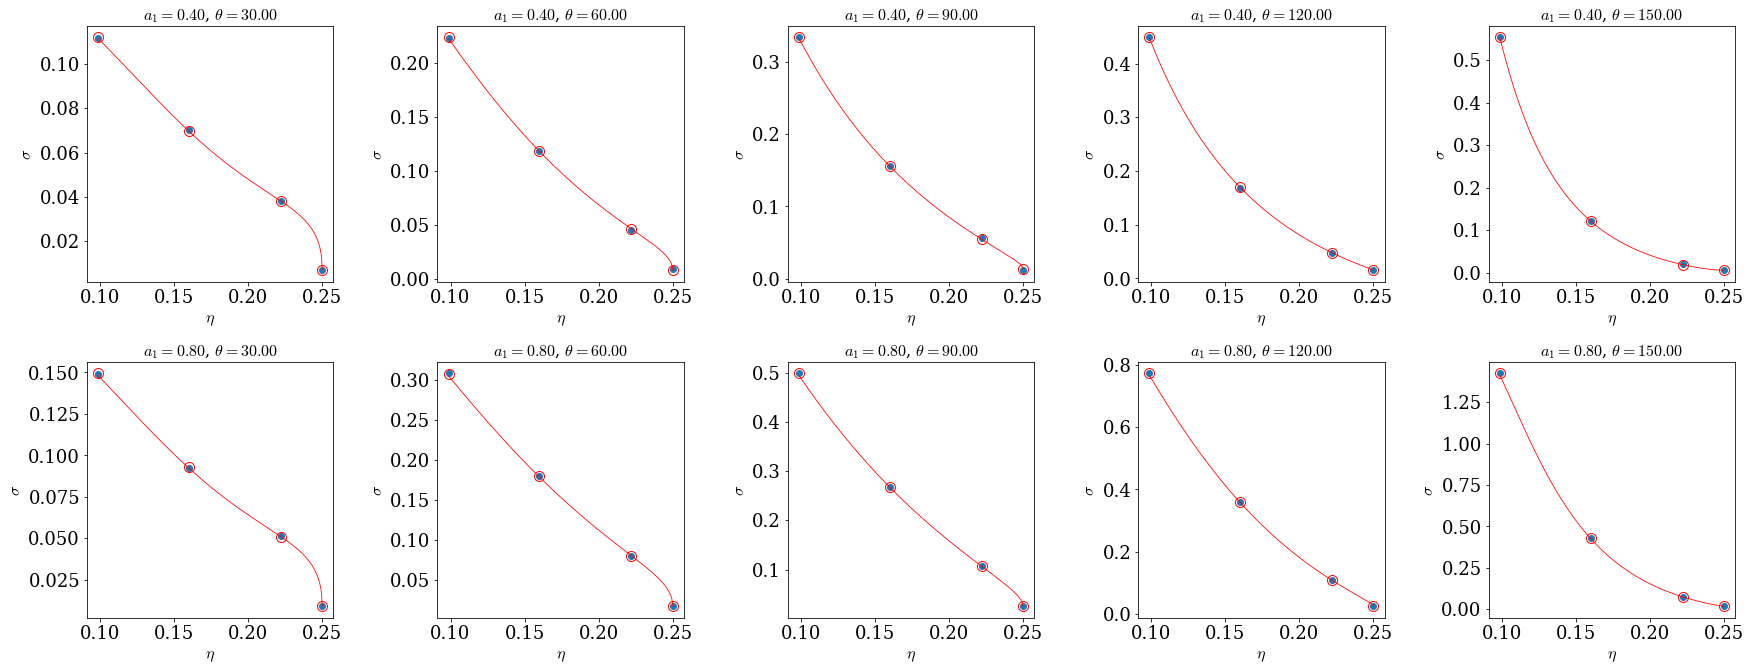

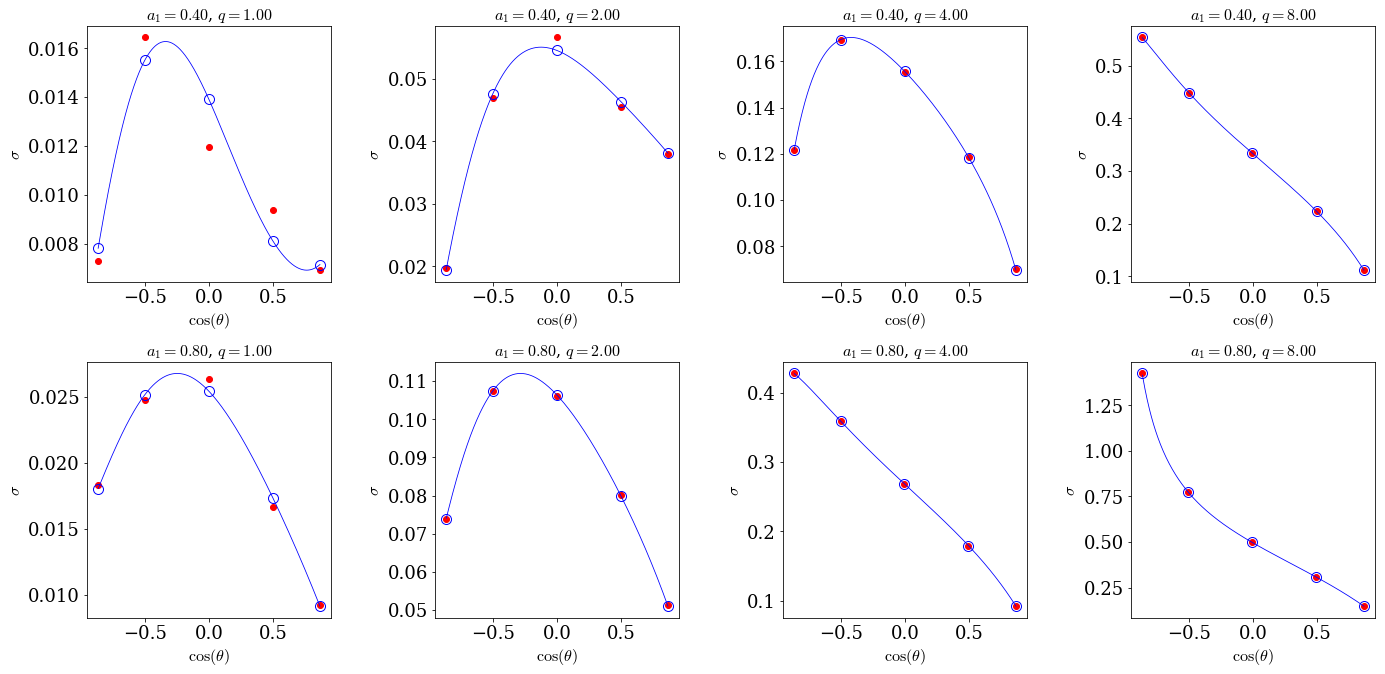

In [437]:
advanced_gmvx_plot(foo,theta_eta_a1=[th_domain*pi/180,eta_domain,a1_domain])

(<Figure size 1890x540 with 3 Axes>,
 <Figure size 1800x720 with 10 Axes>,
 <Figure size 1440x720 with 8 Axes>)

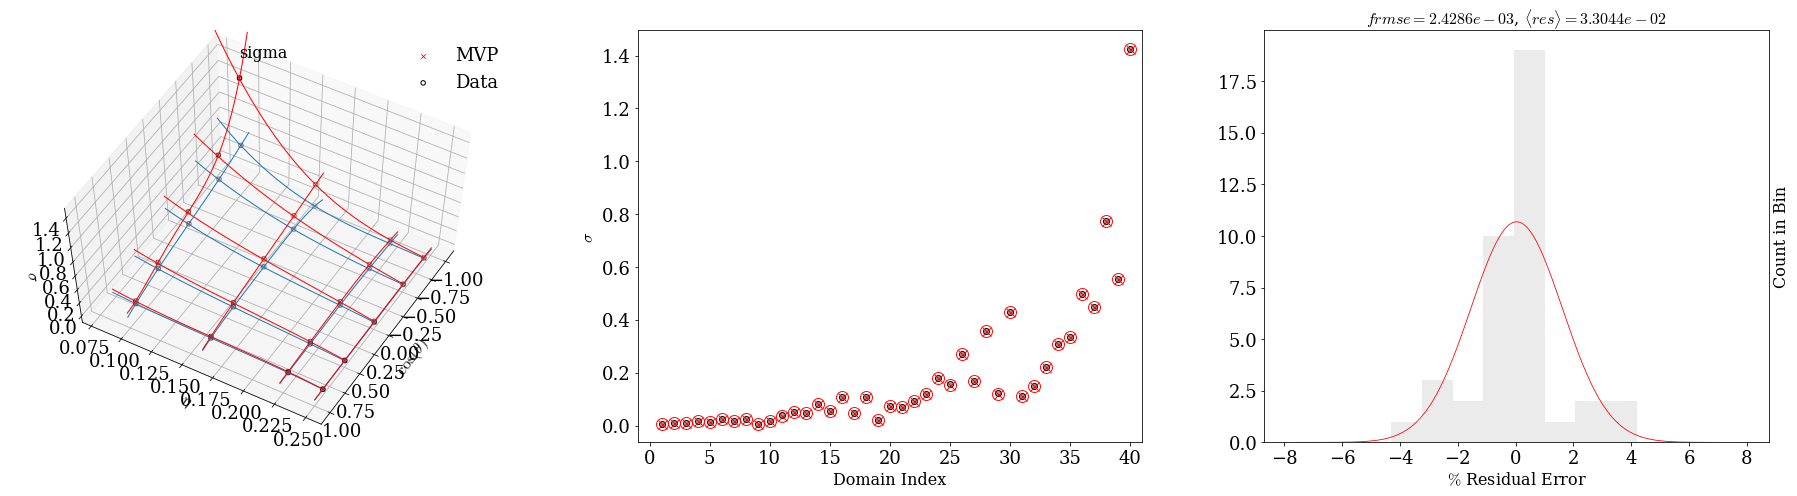

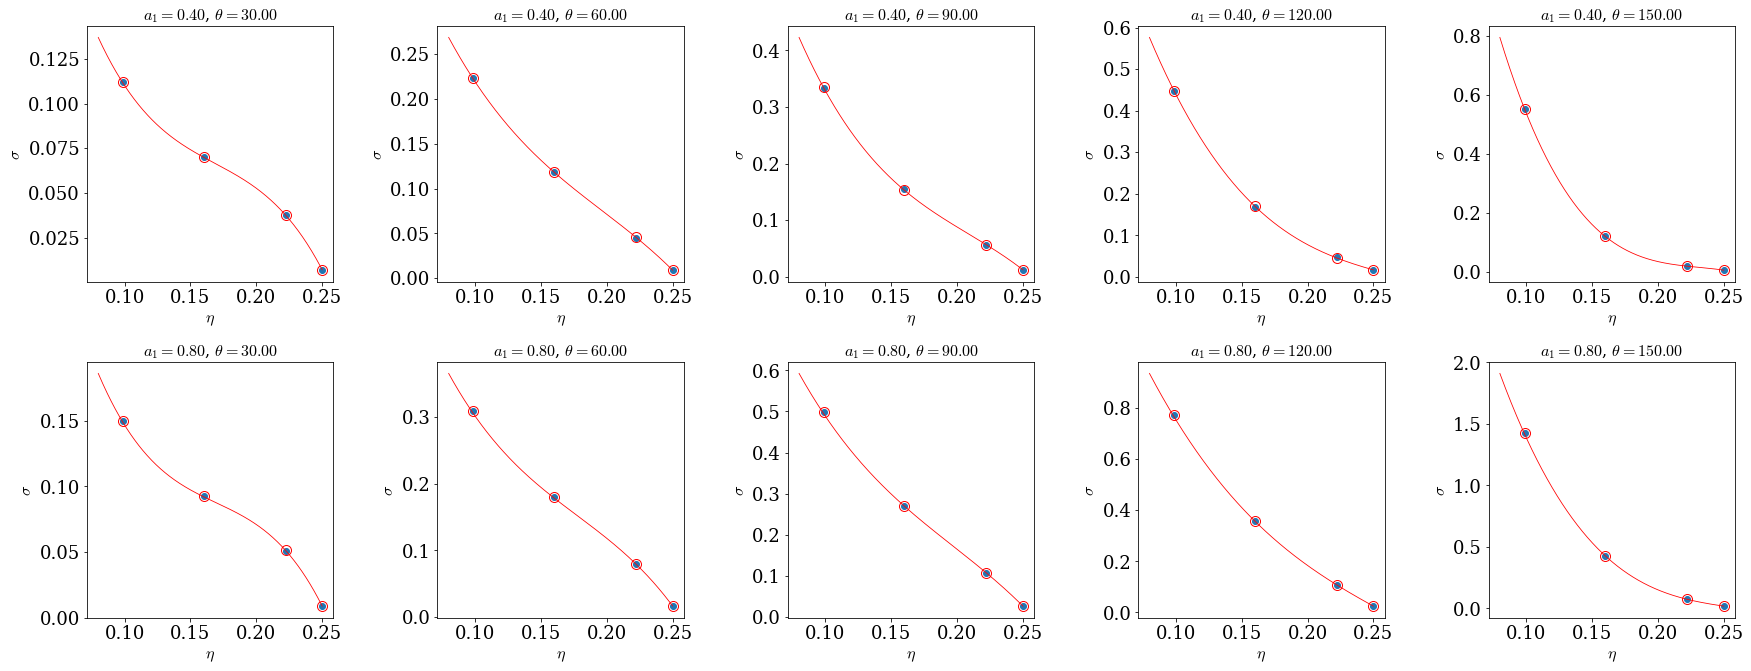

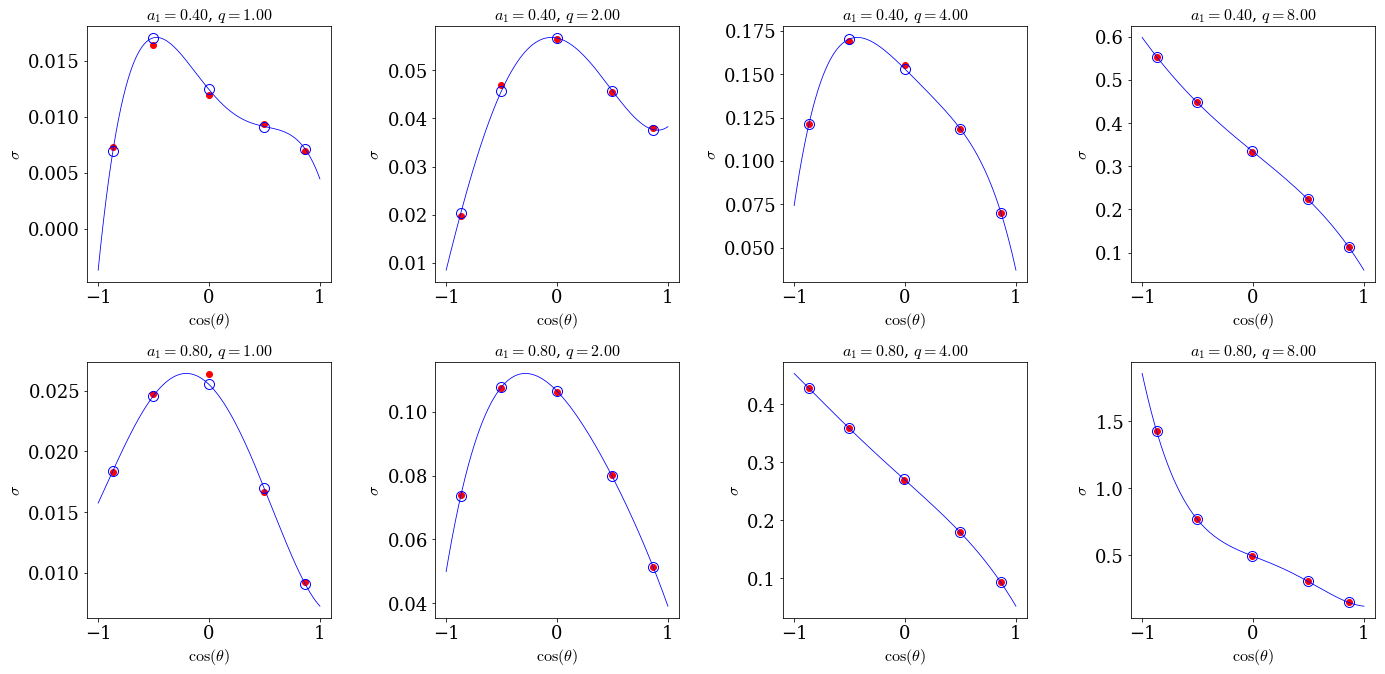

In [443]:
advanced_gmvx_plot(foo2,theta_eta_a1=[th_domain*pi/180,eta_domain,a1_domain],extrap=True)

In [432]:
# 
model_domain = array( [u_domain,eta_domain,delta_domain,a1_domain] ).T
# model_domain = around(model_domain,4)
scalar_range = ( array( mf_range ).T - array( mfnp_range ).T ) / array(chip_domain).T

# #
# mask = argsort(eta_domain)
# model_domain = model_domain[mask,:]
# scalar_range = scalar_range[mask]

foo3 = gmvpfit( model_domain, scalar_range, fitatol=0.0001, verbose=True, maxdeg_list=[4,0,3,1],center=True,estatol=0.0001)

(gmvpfit)>> Now working deg = 1
&& The estimator has changed by -inf
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '2' '0']
&& The current estimator value is 0.671811

(gmvpfit)>> Now working deg = 2
&& The estimator has changed by -0.142908
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '23' '22' '2' '03' '02' '00' '0']
&& The current estimator value is 0.528903

(gmvpfit)>> Now working deg = 3
&& The estimator has changed by -0.344085
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '23' '223' '222' '22' '2' '03' '023' '022' '02' '003' '002' '000'
 '00' '0']
&& The current estimator value is 0.184818

(gmvpfit)>> Now working deg = 4
&& The estimator has changed by -0.061098
&& Degree tempering will continue.
&& The current boundary is ['K' '3' '23' '223' '2223' '222' '22' '2' '03' '023' '0223' '0222' '022'
 '02' '003' '0023' '0022' '002' '0003' '0000' '000' '00' '0']
&& The current estimator value is 0.123720

(gm

(<Figure size 1890x540 with 3 Axes>,
 <Figure size 1800x720 with 10 Axes>,
 <Figure size 1440x720 with 8 Axes>)

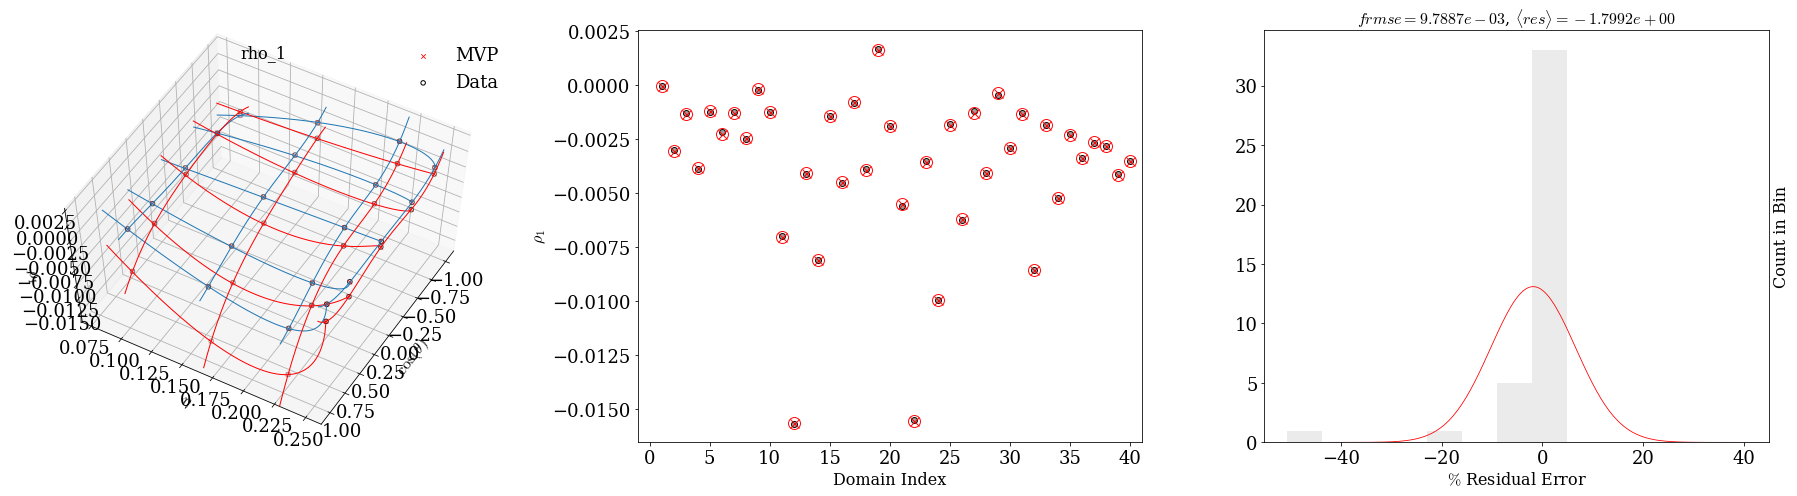

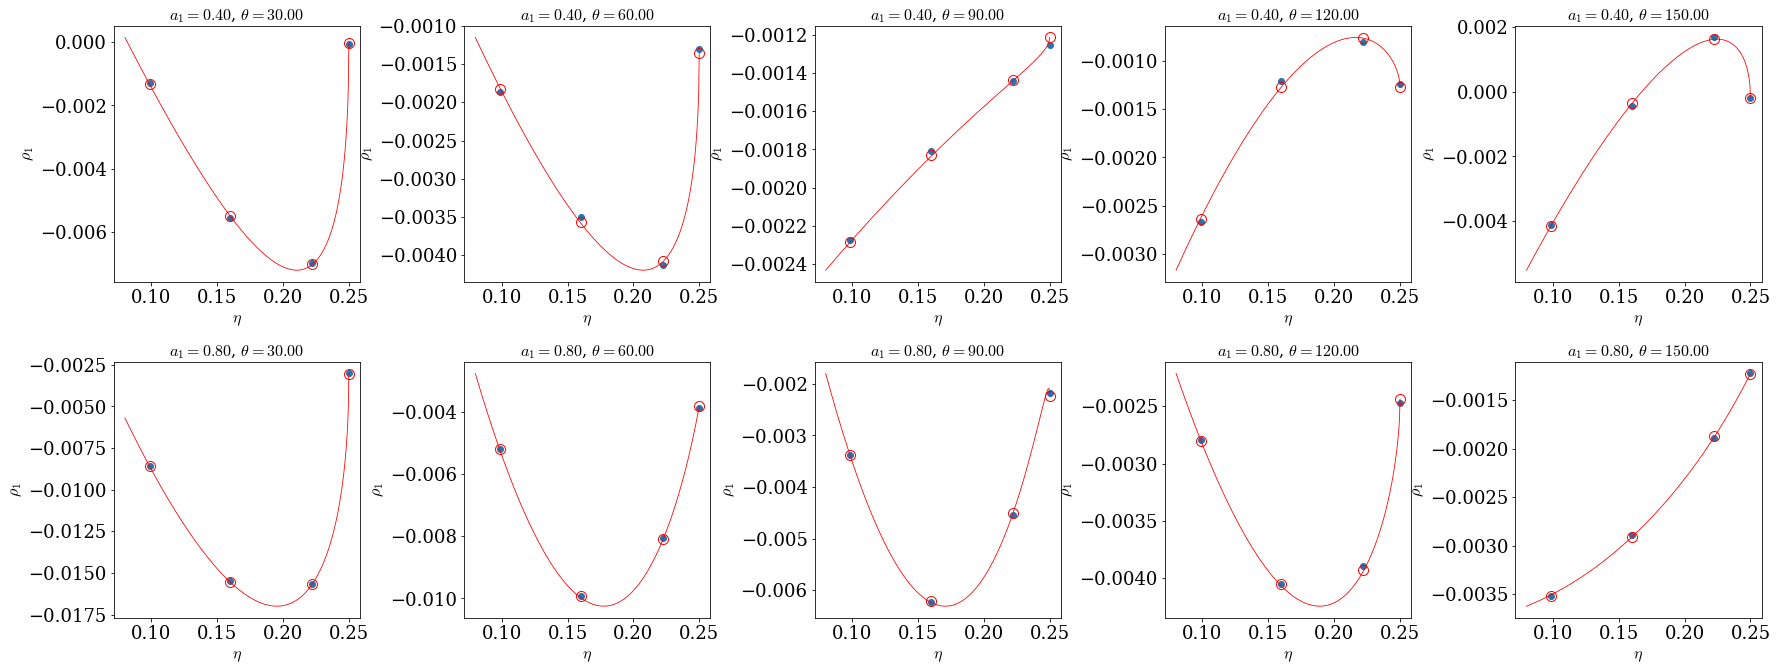

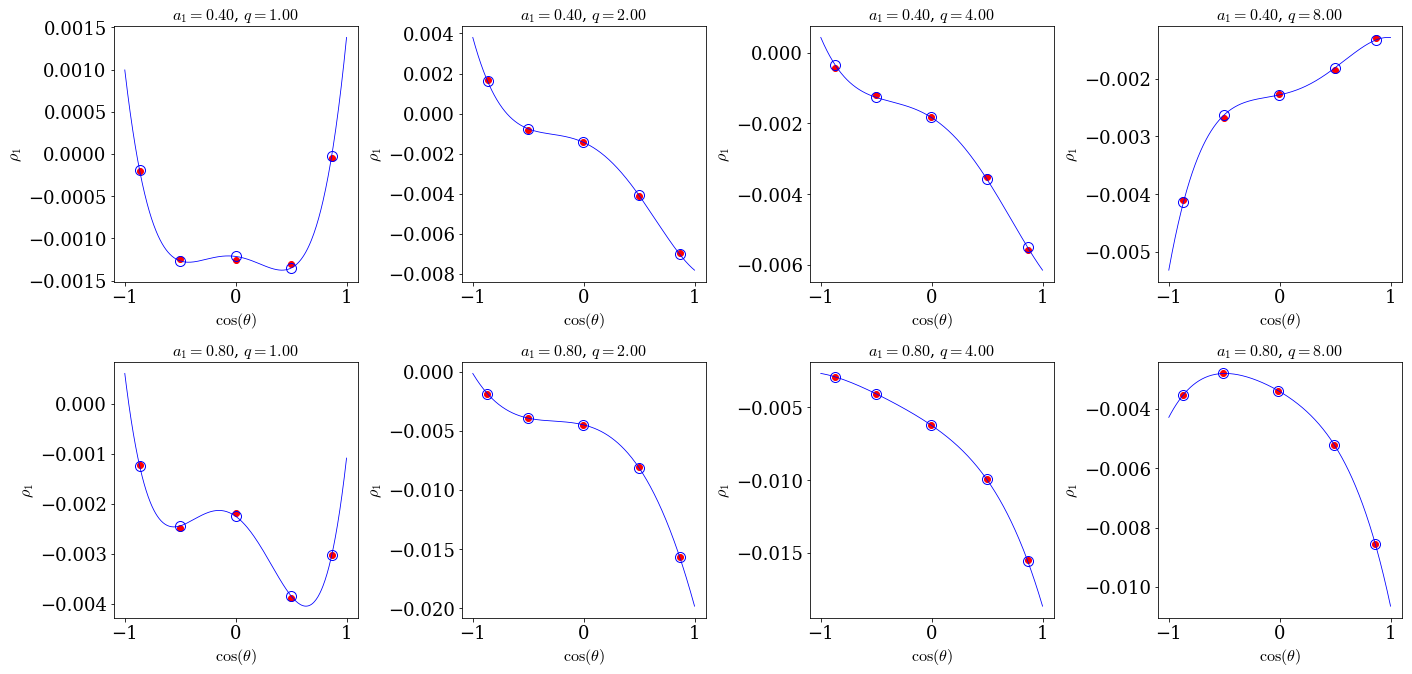

In [445]:
key = 'rho_1'
foo3.labels={'python':[key,('u', 'eta', 'delta', 'a1'),''],'latex':['\\'+key,(r'\cos(\theta)', r'\eta', r'\delta', r'a_1'),'']}
advanced_gmvx_plot(foo3,theta_eta_a1=[th_domain*pi/180,eta_domain,a1_domain],extrap=True)

In [447]:
?foo.__str_python__

Signature: foo.__str_python__(python_labels=None, precision=8)
Docstring:
It's useful to know:

* That "labels" is of the following form
    * labels = [range_label,domain_labels,python_prefix]
    * EXAMPLE: labels = [ 'temperature', ['day','longitude','latitude','aliens_influence_measure'], '' ]
File:      ~/JOKI/Libs/KOALA/positive_dev/positive/learning.py
Type:      instancemethod


In [448]:
foo.__str_python__(precision=10)

'sigma = lambda u,eta,delta,a1: 1.8898790231e-01  +  2.6483063540e-01 * (  -1.1983430720e+00*(u) + -1.3772065116e+00*(u*u*u) + 2.9053891907e+01*(u*u*u*eta) + -4.0404012401e+00*(u*u*u*a1) + 1.0330528104e+02*(u*u*eta*delta) + -2.4028490447e+01*(u*u*eta*a1) + -1.4365845862e+01*(u*u*delta) + -8.4406076267e+00*(u*u*delta*a1) + -1.3490825278e+02*(u*eta*delta*a1) + 1.6562174147e+02*(u*eta*a1) + 4.4735683778e+01*(u*delta*a1) + -4.5885947387e+01*(u*a1) + -7.8550423415e+01*(eta) + -9.3355277400e+00*(eta*delta) + 1.8313346679e+01*(delta*a1) + 1.9917513387e+00*(a1) + 6.7312889872e+00 ) / ( 1.0 +  -2.5643511797e+01*(u*u) + -1.3235866405e+00*(u*u*u) + -1.7439371915e+01*(u*u*u*eta) + 2.0490497157e+00*(u*u*u*a1) + 1.0169592435e+02*(u*u*eta) + -1.7166528327e+02*(u*u*eta*delta) + 2.8637885876e+01*(u*u*eta*a1) + 3.1549016361e+01*(u*u*delta) + -1.7065217117e+01*(u*eta*delta) + 3.2954451080e+01*(u*eta*a1) + 9.0171626712e+00*(u*delta) + 6.9263694152e+01*(eta) + -4.2314987766e+01*(eta*delta*a1) + 7.243488954

In [464]:
#
def mvfo2file(mvfo,output_path,verbose=True):
    
    # Create the file to be written
    f = open(output_path,'w+')
    
    # Create output string 
    code_string = mvfo.__str_python__(precision=10)
    f.writelines(code_string)
    
    # Close file
    f.close()
    
    #
    alert('Fit equations have been saved to %s'%magenta(output_path),verbose=verbose)
    
    #
    return None

In [465]:

# Final spin rational model
key = 'final_spin_rational_sigma_function'
mvfo = foo
mvfo.labels={'python':[key,('u', 'eta', 'delta', 'a1'),''],'latex':['\\'+key,(r'\cos(\theta)', r'\eta', r'\delta', r'a_1'),'']}
outpath = '/Users/book/KOALA/puck/ll/pwca/%s.py'%key
mvfo2file( mvfo, outpath )

# Final spin polynomial model
key = 'final_spin_polynomial_sigma_function'
mvfo = foo2
mvfo.labels={'python':[key,('u', 'eta', 'delta', 'a1'),''],'latex':['\\'+key,(r'\cos(\theta)', r'\eta', r'\delta', r'a_1'),'']}
outpath = '/Users/book/KOALA/puck/ll/pwca/%s.py'%key
mvfo2file( foo2, outpath )

# Final mass polynomial model
key = 'final_mass_polynomial_rho_function'
mvfo = foo3
mvfo.labels={'python':[key,('u', 'eta', 'delta', 'a1'),''],'latex':['\\'+key,(r'\cos(\theta)', r'\eta', r'\delta', r'a_1'),'']}
outpath = '/Users/book/KOALA/puck/ll/pwca/%s.py'%key
mvfo2file( mvfo, outpath )


(mvfo2file)>> Fit equations have been saved to /Users/book/KOALA/puck/ll/pwca/final_spin_rational_sigma_function.py
(mvfo2file)>> Fit equations have been saved to /Users/book/KOALA/puck/ll/pwca/final_spin_polynomial_sigma_function.py
(mvfo2file)>> Fit equations have been saved to /Users/book/KOALA/puck/ll/pwca/final_mass_polynomial_rho_function.py
